# Portfolio vs S&P 500: Market Views and Stress-Tests
Replicating the Chapter 7.2 framework for a 12-asset portfolio against S&P 500.

In [1]:
!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy seaborn yfinance

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 32.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 101.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 22.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 166.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 103.3 MB/s eta 0:00:00a 0:00:01
  Created w

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load data and compute portfolio returns

In [68]:
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

selected_assets = [
    'NVDA', 'ISRG', 'APO', 'DECK', 'COST', 'CAT', 
    'BTU', 'SHW', 'NRG', 'NFLX', 'CBRE', 'GC=F'
]
benchmark = '^GSPC'
all_assets = selected_assets + [benchmark]

existing_assets = [c for c in all_assets if c in data.columns]
data = data[existing_assets]
data = data[data > 0]
data_clean = data.dropna(axis=0, how='any')

pnl = np.diff(np.log(data_clean.values), axis=0)
pnl = pd.DataFrame(pnl, index=data_clean.index[1:], columns=data_clean.columns)

print(f"Returns: {pnl.shape[0]} days × {pnl.shape[1]} assets")
print(f"Date range: {pnl.index[0].date()} → {pnl.index[-1].date()}")

Returns: 2470 days × 13 assets
Date range: 2016-01-05 → 2025-11-11


In [69]:
# Portfolio weights - 20-fold exposure stacking from optimization
exposures = np.array([
    0.0413,  # NVDA
    0.0516,  # ISRG
    0.0414,  # APO
    0.0597,  # DECK
    0.1624,  # COST
    0.0901,  # CAT
    0.0240,  # BTU
    0.0992,  # SHW
    0.0790,  # NRG
    0.0707,  # NFLX
    0.0519,  # CBRE
    0.2286,  # GC=F
])

# Extract investable returns and benchmark
R_investable = pnl[selected_assets].values
R_benchmark = pnl[benchmark].values

# Compute portfolio return series
portfolio_return = R_investable @ exposures

# Specify prior parameters and simulate

In [91]:
# Annualize for simulation (H = 252 trading days)
H = 42

# Stack portfolio and benchmark for 2-asset analysis
returns_2d = np.column_stack([portfolio_return, R_benchmark])
means = np.mean(returns_2d, axis=0) * H
vols = np.std(returns_2d, axis=0) * np.sqrt(H)
corr = np.corrcoef(returns_2d.T)
covariances = np.diag(vols) @ corr @ np.diag(vols)

print(f"Portfolio: mean={means[0]*100:.1f}%, vol={vols[0]*100:.1f}%")
print(f"S&P 500:   mean={means[1]*100:.1f}%, vol={vols[1]*100:.1f}%")
print(f"Correlation: {corr[0,1]:.3f}")

Portfolio: mean=3.5%, vol=6.9%
S&P 500:   mean=2.1%, vol=7.5%
Correlation: 0.887


In [92]:
# Simulate log-normal returns
S = 10000
np.random.seed(1337)
log_return = np.random.multivariate_normal(means, covariances, S)
discrete_return = pd.DataFrame(
    np.exp(log_return - np.diag(np.cov(log_return.T)) / 2) - 1,
    columns=['Portfolio', 'S&P 500'])

In [93]:
# Validate simulation
ft.simulation_moments(100 * discrete_return)

,Mean,Volatility,Skewness,Kurtosis
Portfolio,3.601008,7.163402,0.227097,3.023476
S&P 500,2.117824,7.523943,0.227864,3.014958


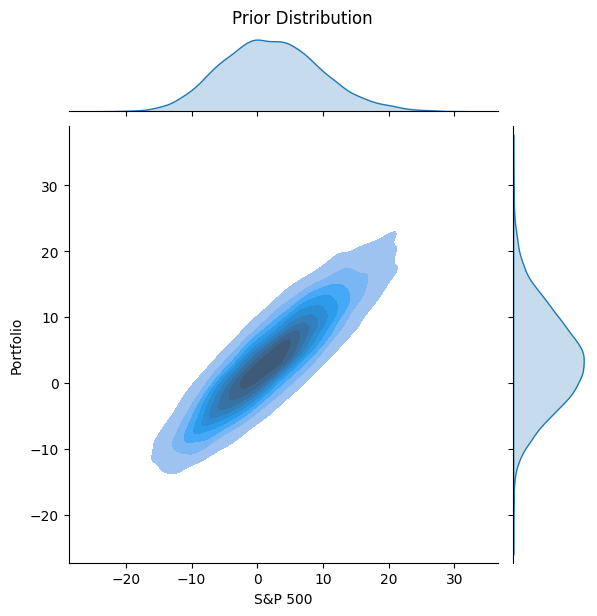

In [94]:
# Joint plot - Prior distribution (Figure 7.2.1 equivalent)
sns.jointplot(data=100 * discrete_return, x='S&P 500', y='Portfolio', kind='kde', fill=True)
plt.suptitle('Prior Distribution', y=1.02)
plt.show()

# View on S&P 500 (mean and variance)

In [95]:
prior_stats = ft.simulation_moments(discrete_return, p)
prior_mean_sp = prior_stats['Mean']['S&P 500']
prior_vol_sp = prior_stats['Volatility']['S&P 500']

print(f"Prior S&P: mean={prior_mean_sp:.3%}, vol={prior_vol_sp:.3%}")

mean_mult = 1.1   # mean
vol_mult = 1.3    # vol 

view_mean = mean_mult * prior_mean_sp
view_vol = vol_mult * prior_vol_sp

print(f"View S&P:  mean={view_mean:.3%}, vol={view_vol:.3%}")

A = np.ones((1, S))
A = np.vstack((A, discrete_return.values[:, 1]))                    #
A = np.vstack((A, discrete_return.values[:, 1]**2))                 
b = np.array([[1., view_mean, view_vol**2 + view_mean**2]]).T   

Prior S&P: mean=2.118%, vol=7.524%
View S&P:  mean=2.330%, vol=9.781%


In [96]:
p = np.ones((S, 1)) / S
q_view = ft.entropy_pooling(p, A, b)
relative_entropy_view = q_view.T @ (np.log(q_view) - np.log(p))
effective_number_scenarios_view = np.exp(-relative_entropy_view)
print(f'Effective number of scenarios view = {np.round(effective_number_scenarios_view[0, 0] * 100, 2)}%.')
print(f'Relative entropy view = {np.round(relative_entropy_view[0, 0] * 100, 2)}%.')

Effective number of scenarios view = 91.93%.
Relative entropy view = 8.41%.


In [97]:
# Validate view implementation
np.round(ft.simulation_moments(100 * discrete_return, p=q_view), 3)

,Mean,Volatility,Skewness,Kurtosis
Portfolio,3.75,8.832,0.285,2.864
S&P 500,2.33,9.781,0.329,2.886


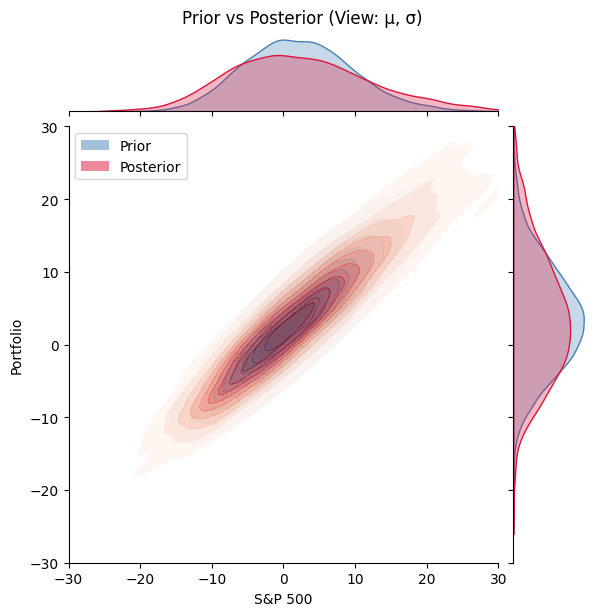

In [98]:
g = sns.JointGrid(data=100 * discrete_return, x='S&P 500', y='Portfolio')

sns.kdeplot(data=100 * discrete_return, x='S&P 500', y='Portfolio', 
            fill=True, ax=g.ax_joint, cmap='Blues', alpha=0.5)
sns.kdeplot(data=100 * discrete_return, x='S&P 500', y='Portfolio', 
            weights=q_view[:, 0], fill=True, ax=g.ax_joint, cmap='Reds', alpha=0.5)

sns.kdeplot(x=100 * discrete_return['S&P 500'], ax=g.ax_marg_x, color='steelblue', fill=True, alpha=0.3)
sns.kdeplot(x=100 * discrete_return['S&P 500'], weights=q_view[:, 0], ax=g.ax_marg_x, color='crimson', fill=True, alpha=0.3)
sns.kdeplot(y=100 * discrete_return['Portfolio'], ax=g.ax_marg_y, color='steelblue', fill=True, alpha=0.3)
sns.kdeplot(y=100 * discrete_return['Portfolio'], weights=q_view[:, 0], ax=g.ax_marg_y, color='crimson', fill=True, alpha=0.3)

legend_handles = [Patch(facecolor='steelblue', alpha=0.5, label='Prior'),
                  Patch(facecolor='crimson', alpha=0.5, label='Posterior')]
g.ax_joint.legend(handles=legend_handles, loc='upper left')
g.figure.suptitle('Prior vs Posterior (View: μ, σ)', y=1.02)
g.ax_joint.set_xlim(-30, 30)
g.ax_joint.set_ylim(-30, 30)
plt.show()

# C0 Stress-Test: Portfolio at CVaR

In [99]:
# Compute portfolio CVaR
pf_exposures = np.array([[1.], [0.]])  # 100% portfolio, 0% benchmark
portfolio_cvar = ft.portfolio_cvar(pf_exposures, discrete_return, alpha=0.9, demean=False)
print(f'Portfolio 90%-CVaR = {np.round(100 * portfolio_cvar, 3)}%')

Portfolio 90%-CVaR = 8.3%


In [100]:
# C0: Condition on portfolio return = CVaR
A0 = np.ones((1, S))
A0 = np.vstack((A0, discrete_return.values[:, 0]))  # Portfolio return
b0 = np.array([[1., -portfolio_cvar]]).T
q0 = ft.entropy_pooling(p, A0, b0)

In [101]:
relative_entropy_0 = q0.T @ (np.log(q0) - np.log(p))
effective_number_scenarios_0 = np.exp(-relative_entropy_0)
print(f'Effective number of scenarios intermediate stress-test = {np.round(effective_number_scenarios_0[0, 0] * 100, 2)}%.')
print(f'Relative entropy intermediate stress-test = {np.round(relative_entropy_0[0, 0] * 100, 2)}%.')

Effective number of scenarios intermediate stress-test = 20.4%.
Relative entropy intermediate stress-test = 158.99%.


In [102]:
# Validate that portfolio expected return equals CVaR
stats0 = ft.simulation_moments(discrete_return, q0)
display(np.round(stats0, 3))
print(f'Portfolio 90%-CVaR = {np.round(100 * portfolio_cvar, 3)}%')

,Mean,Volatility,Skewness,Kurtosis
Portfolio,-0.083,0.060,0.003,3.229
S&P 500,-0.090,0.065,0.069,3.081


Portfolio 90%-CVaR = 8.3%


# C4 Stress-Test: Correlation spike

In [51]:
# C4: Add correlation constraint (spike to 0.90)
stress_correlation = 0.90

A4 = np.ones((1, S))
# Means
A4 = np.vstack((A4, discrete_return.values[:, 0:2].T))
# Volatilities
A4 = np.vstack((A4, (discrete_return.values[:, 0:2].T - stats0['Mean'].values[0:2][:, np.newaxis])**2))
# Correlation
A4 = np.vstack((A4, (discrete_return.values[:, 0] - stats0['Mean'].values[0]) * 
                    (discrete_return.values[:, 1] - stats0['Mean'].values[1]) /
                    (stats0['Volatility'].values[0] * stats0['Volatility'].values[1])))

b4 = np.array([[1., *stats0['Mean'].iloc[0:2], *stats0['Volatility'].iloc[0:2]**2, stress_correlation]]).T

In [52]:
q_stress = ft.entropy_pooling(p, A4, b4)
relative_entropy_stress = q_stress.T @ (np.log(q_stress) - np.log(p))
effective_number_scenarios_stress = np.exp(-relative_entropy_stress)
print(f'Effective number of scenarios stress-test = {np.round(effective_number_scenarios_stress[0, 0] * 100, 2)}%.')
print(f'Relative entropy stress-test = {np.round(relative_entropy_stress[0, 0] * 100, 2)}%.')

Effective number of scenarios stress-test = 20.23%.
Relative entropy stress-test = 159.79%.


In [53]:
# Validate final posterior values
stats_q = ft.simulation_moments(discrete_return, q_stress)
display(np.round(stats_q, 3))
print(f'Portfolio 90%-CVaR = {np.round(100 * portfolio_cvar, 3)}%')

,Mean,Volatility,Skewness,Kurtosis
Portfolio,-0.083,0.060,0.014,3.216
S&P 500,-0.090,0.065,0.071,3.100


Portfolio 90%-CVaR = 8.3%


In [54]:
# Validate final posterior correlations
ft.correlation_matrix(discrete_return, q_stress)

,0,1
"(0, Portfolio)",1.0,0.9
"(1, S&P 500)",0.9,1.0


# Comparison plots

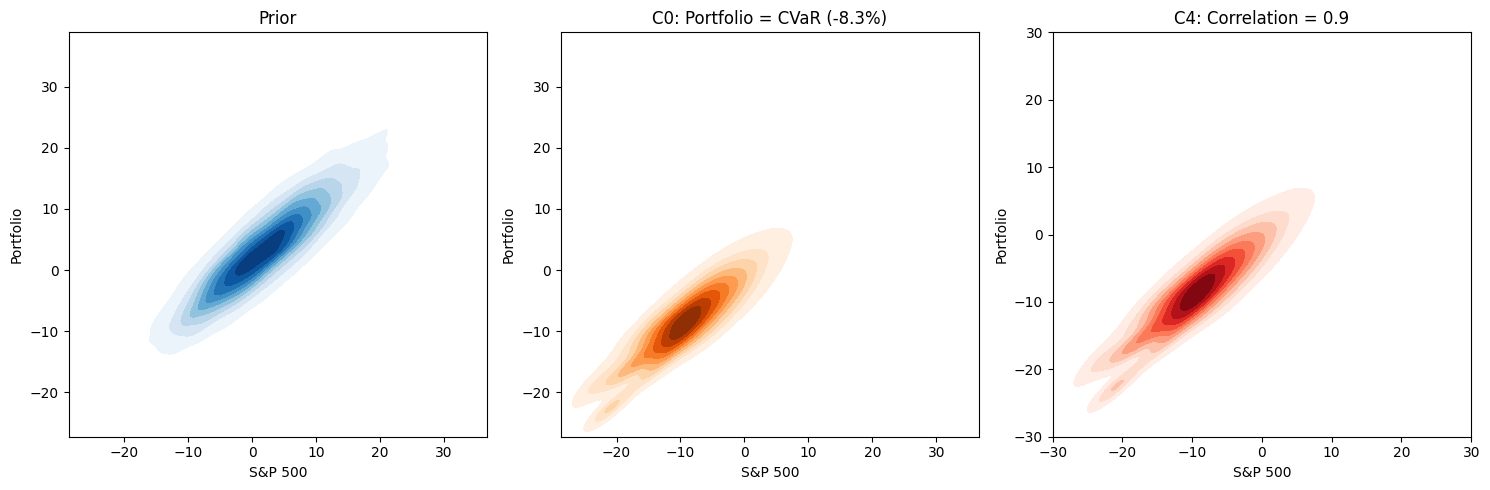

In [57]:
# Prior distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Prior
ax1 = axes[0]
sns.kdeplot(data=100 * discrete_return, x='S&P 500', y='Portfolio', 
            fill=True, ax=ax1, cmap='Blues')
ax1.set_title('Prior')
ax3.set_xlim(-30, 30)
ax3.set_ylim(-30, 30)

# C0: Portfolio at CVaR
ax2 = axes[1]
sns.kdeplot(data=100 * discrete_return, x='S&P 500', y='Portfolio', 
            weights=q0[:, 0], fill=True, ax=ax2, cmap='Oranges')
ax2.set_title(f'C0: Portfolio = CVaR ({-portfolio_cvar*100:.1f}%)')
ax3.set_xlim(-30, 30)
ax3.set_ylim(-30, 30)

# C4: Correlation stress
ax3 = axes[2]
sns.kdeplot(data=100 * discrete_return, x='S&P 500', y='Portfolio', 
            weights=q_stress[:, 0], fill=True, ax=ax3, cmap='Reds')
ax3.set_title(f'C4: Correlation = {stress_correlation}')
ax3.set_xlim(-30, 30)
ax3.set_ylim(-30, 30)

plt.tight_layout()
plt.show()

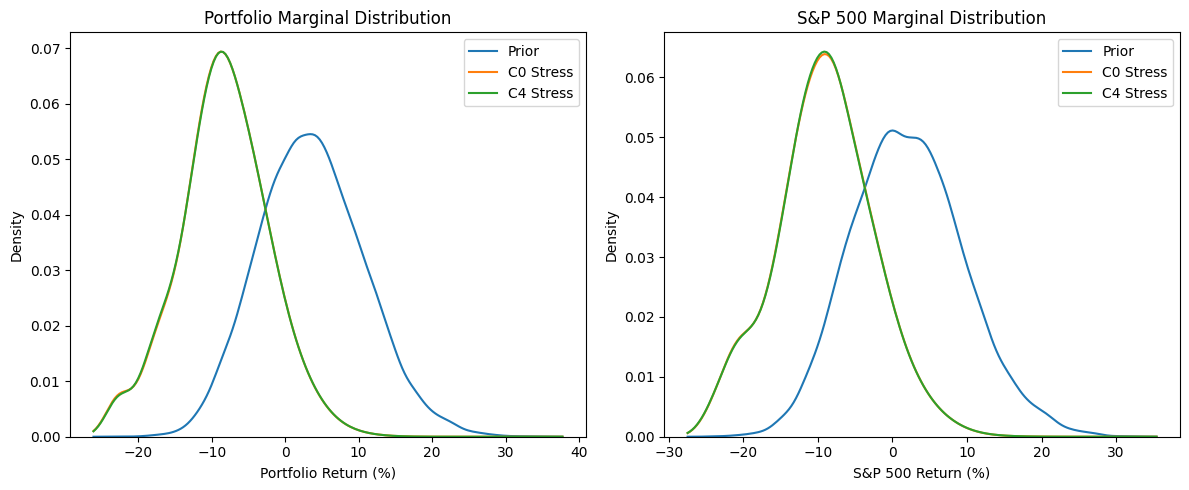

In [58]:
# Marginal distributions comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Portfolio marginal
ax1 = axes[0]
sns.kdeplot(x=100 * discrete_return['Portfolio'], ax=ax1, label='Prior')
sns.kdeplot(x=100 * discrete_return['Portfolio'], weights=q0[:, 0], ax=ax1, label='C0 Stress')
sns.kdeplot(x=100 * discrete_return['Portfolio'], weights=q_stress[:, 0], ax=ax1, label='C4 Stress')
ax1.set_xlabel('Portfolio Return (%)')
ax1.set_title('Portfolio Marginal Distribution')
ax1.legend()

# S&P 500 marginal
ax2 = axes[1]
sns.kdeplot(x=100 * discrete_return['S&P 500'], ax=ax2, label='Prior')
sns.kdeplot(x=100 * discrete_return['S&P 500'], weights=q0[:, 0], ax=ax2, label='C0 Stress')
sns.kdeplot(x=100 * discrete_return['S&P 500'], weights=q_stress[:, 0], ax=ax2, label='C4 Stress')
ax2.set_xlabel('S&P 500 Return (%)')
ax2.set_title('S&P 500 Marginal Distribution')
ax2.legend()

plt.tight_layout()
plt.show()

In [59]:
# Summary table
summary = pd.DataFrame({
    'Prior': [
        ft.simulation_moments(discrete_return, p)['Mean']['Portfolio'] * 100,
        ft.simulation_moments(discrete_return, p)['Volatility']['Portfolio'] * 100,
        ft.correlation_matrix(discrete_return, p).iloc[0, 1],
        100.0
    ],
    'C0 Stress': [
        stats0['Mean']['Portfolio'] * 100,
        stats0['Volatility']['Portfolio'] * 100,
        ft.correlation_matrix(discrete_return, q0).iloc[0, 1],
        effective_number_scenarios_0[0, 0] * 100
    ],
    'C4 Stress': [
        stats_q['Mean']['Portfolio'] * 100,
        stats_q['Volatility']['Portfolio'] * 100,
        ft.correlation_matrix(discrete_return, q_stress).iloc[0, 1],
        effective_number_scenarios_stress[0, 0] * 100
    ]
}, index=['Portfolio Mean (%)', 'Portfolio Vol (%)', 'Correlation', 'Effective Scenarios (%)'])

np.round(summary, 3)

,Prior,C0 Stress,C4 Stress
Portfolio Mean (%),3.601,-8.300,-8.300
Portfolio Vol (%),7.163,6.037,6.037
Correlation,0.887,0.880,0.900
Effective Scenarios (%),100.000,20.395,20.232


# Alternative: S&P 500 crash stress test

In [60]:
# Stress test: S&P 500 at its CVaR
sp500_cvar = ft.portfolio_cvar(np.array([[0.], [1.]]), discrete_return, alpha=0.9, demean=False)
print(f'S&P 500 90%-CVaR = {np.round(100 * sp500_cvar, 3)}%')
A_sp = np.ones((1, S))
A_sp = np.vstack((A_sp, discrete_return.values[:, 1]))
b_sp = np.array([[1., -sp500_cvar]]).T
q_sp_stress = ft.entropy_pooling(p, A_sp, b_sp)

# Relative entropy and effective scenarios
relative_entropy_sp = q_sp_stress.T @ (np.log(q_sp_stress) - np.log(p))
effective_number_scenarios_sp = np.exp(-relative_entropy_sp)
print(f'Effective number of scenarios S&P crash = {np.round(effective_number_scenarios_sp[0, 0] * 100, 2)}%.')
print(f'Relative entropy S&P crash = {np.round(relative_entropy_sp[0, 0] * 100, 2)}%.')

print(f"\nWhen S&P 500 is at its CVaR ({-sp500_cvar*100:.1f}%):")
stats_sp = ft.simulation_moments(discrete_return, q_sp_stress)
display(np.round(stats_sp, 3))

# Prior and Posterior Correlations
print("\n" + "="*60)
print("CORRELATION COMPARISON")
print("="*60)

corr_prior = ft.correlation_matrix(discrete_return, p)
corr_posterior = ft.correlation_matrix(discrete_return, q_sp_stress)
corr_diff = corr_posterior - corr_prior

print("\nPrior Correlation Matrix:")
display(np.round(corr_prior, 3))

print("\nPosterior Correlation Matrix (S&P Crash):")
display(np.round(corr_posterior, 3))

print("\nCorrelation Change (Posterior - Prior):")
display(np.round(corr_diff, 3))

S&P 500 90%-CVaR = 10.327%
Effective number of scenarios S&P crash = 20.8%.
Relative entropy S&P crash = 157.0%.

When S&P 500 is at its CVaR (-10.3%):


,Mean,Volatility,Skewness,Kurtosis
Portfolio,-0.069,0.061,0.089,3.165
S&P 500,-0.103,0.063,0.104,2.995



CORRELATION COMPARISON

Prior Correlation Matrix:


,0,1
"(0, Portfolio)",1.000,0.887
"(1, S&P 500)",0.887,1.000



Posterior Correlation Matrix (S&P Crash):


,0,1
"(0, Portfolio)",1.000,0.869
"(1, S&P 500)",0.869,1.000



Correlation Change (Posterior - Prior):


,0,1
"(0, Portfolio)",0.000,-0.017
"(1, S&P 500)",-0.017,0.000


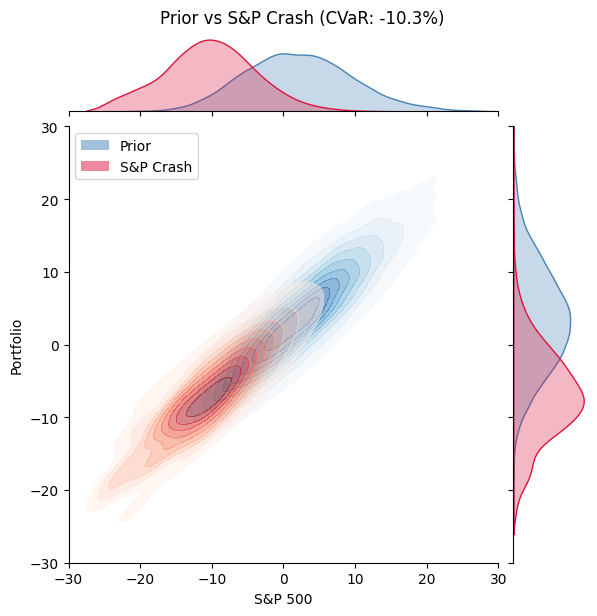

In [62]:
g = sns.JointGrid(data=100 * discrete_return, x='S&P 500', y='Portfolio')
sns.kdeplot(data=100 * discrete_return, x='S&P 500', y='Portfolio', 
            fill=True, ax=g.ax_joint, cmap='Blues', alpha=0.5)
sns.kdeplot(data=100 * discrete_return, x='S&P 500', y='Portfolio', 
            weights=q_sp_stress[:, 0], fill=True, ax=g.ax_joint, cmap='Reds', alpha=0.5)
sns.kdeplot(x=100 * discrete_return['S&P 500'], ax=g.ax_marg_x, color='steelblue', fill=True, alpha=0.3)
sns.kdeplot(x=100 * discrete_return['S&P 500'], weights=q_sp_stress[:, 0], ax=g.ax_marg_x, color='crimson', fill=True, alpha=0.3)
sns.kdeplot(y=100 * discrete_return['Portfolio'], ax=g.ax_marg_y, color='steelblue', fill=True, alpha=0.3)
sns.kdeplot(y=100 * discrete_return['Portfolio'], weights=q_sp_stress[:, 0], ax=g.ax_marg_y, color='crimson', fill=True, alpha=0.3)

g.ax_joint.set_xlim(-30, 30)
g.ax_joint.set_ylim(-30, 30)

legend_handles = [Patch(facecolor='steelblue', alpha=0.5, label='Prior'),
                  Patch(facecolor='crimson', alpha=0.5, label='S&P Crash')]
g.ax_joint.legend(handles=legend_handles, loc='upper left')
g.figure.suptitle(f'Prior vs S&P Crash (CVaR: {-sp500_cvar*100:.1f}%)', y=1.02)
plt.show()